In [1]:
path = 'C:/dataset'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import math
import cv2

In [3]:
categories = ['train', 'test', 'val', 'auto_test'] # 전처리된 데이터셋을 훈련용, 평가용, 검증용으로 구분
data_dir = path+'/osteoarthritis/'
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu') # Mac OS
device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

In [4]:
def resize_image(img,size=(128,128)):
    return cv2.resize(img,size)

def he_img(img):
    return cv2.equalizeHist(img)

def clahe_image(img):
    clahe = cv2.createCLAHE(clipLimit=2.,tileGridSize=(8,8))
    cl_img = clahe.apply(img)
    return cl_img

def denoise_img(img):
    return cv2.fastNlMeansDenoising(img,None,30,7,21)

def normalize_img(img):
    return cv2.normalize(img,None,0,255,cv2.NORM_MINMAX)

def detect_edge(img):
    return cv2.Canny(img,100,200)

def blur_img(img):
    return cv2.GaussianBlur(img,(5,5),0)

def find_contour(img):
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    contours, hiearchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

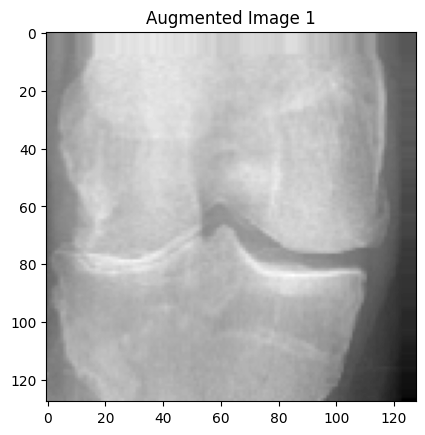

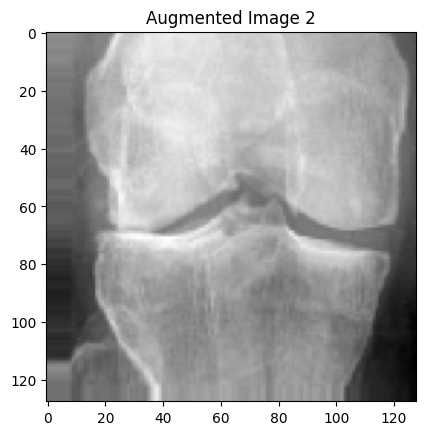

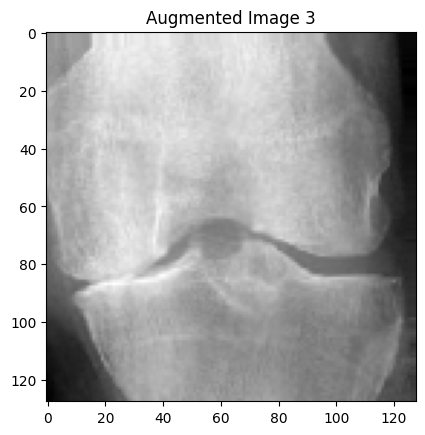

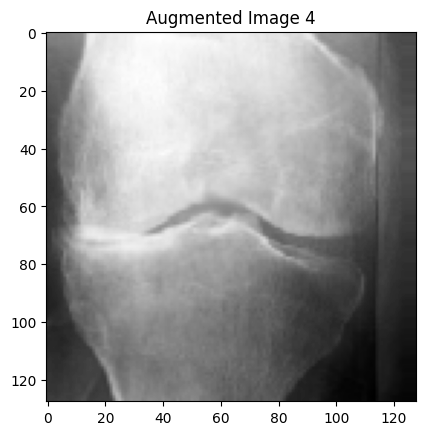

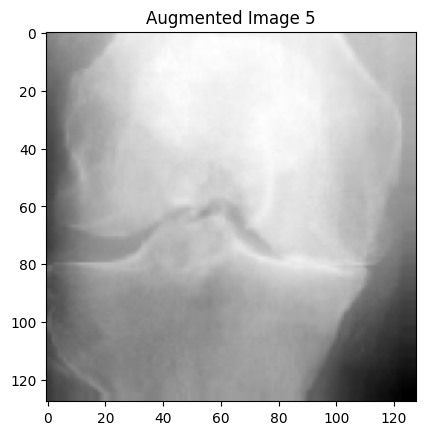

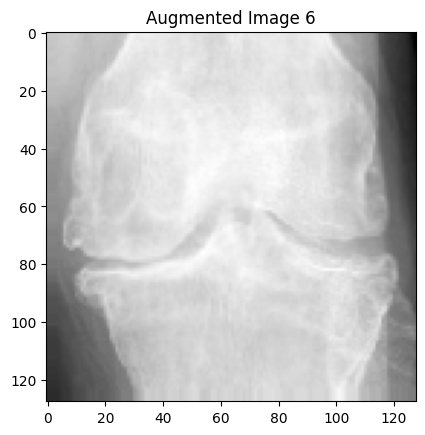

In [5]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest'
)

def augment_images(data_dir, label, augment_count=500):
    label_path = os.path.join(data_dir, 'train', str(label))
    augmented_dir = os.path.join(label_path, 'augmented')
    os.makedirs(augmented_dir, exist_ok=True)

    img_names = os.listdir(label_path)
    img_names = [name for name in img_names if os.path.isfile(os.path.join(label_path, name))]
    generated_count = 0

    while generated_count < augment_count:
        img_name = np.random.choice(img_names)
        img_path = os.path.join(label_path, img_name)
        try:
            img = load_img(img_path, color_mode='grayscale', target_size=(128, 128))
            img = img_to_array(img)
            img = img.reshape((1,) + img.shape)

            for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_dir, save_prefix='aug', save_format='png'):
                generated_count += 1
                break  # 한 장만 생성하고 반복문 탈출
        except PermissionError:
            print(f"Permission denied: Unable to access file {img_path}")
        except Exception as e:
            print(f"Error processing file {img_path}: {e}")

# Augment images in label 4
# data_dir = path+'/osteoarthritis/train/'  # 적절한 데이터 디렉토리로 변경
augment_images(data_dir, 4)

# Display augmented images
augmented_img_paths = os.listdir(os.path.join(data_dir, 'train', '4', 'augmented'))
augmented_img_paths = shuffle(augmented_img_paths)[:6]  # 무작위로 6개 선택

for i, img_name in enumerate(augmented_img_paths):
    img_path = os.path.join(data_dir, 'train', '4', 'augmented', img_name)
    img = load_img(img_path, color_mode='grayscale', target_size=(128, 128))
    plt.imshow(img, cmap='gray')
    plt.title(f'Augmented Image {i + 1}')
    plt.show()


In [6]:
def load_data(data_dir):
    images = []
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        if os.path.isfile(img_path):  # 파일인지 확인
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:  # 이미지가 정상적으로 로드되었는지 확인
                img = resize_image(img)
                img = clahe_image(img)
                img = normalize_img(img)
                images.append(img)
    prepared_data = np.array(images)
    return prepared_data

def load_and_augment_data(data_dir, label):
    label_path = os.path.join(data_dir, 'train', str(label))
    augmented_dir = os.path.join(label_path, 'augmented')

    images = []
    # Load original images
    for img_name in os.listdir(label_path):
        if img_name.endswith('.png'):
            img_path = os.path.join(label_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = resize_image(img)
                img = clahe_image(img)
                img = normalize_img(img)
                images.append(img)
    
    # Load augmented images
    if os.path.exists(augmented_dir):
        for img_name in os.listdir(augmented_dir):
            img_path = os.path.join(augmented_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = resize_image(img)
                img = clahe_image(img)
                img = normalize_img(img)
                images.append(img)
    
    return np.array(images)

# 증강 or 클래스 별 동일한 숫자
# 전체적으로 분류할 때 비율을 맞춰보는게..
# 증강(rotation, zoomin)


In [7]:
# 각 카테고리와 라벨에 따라 이미지를 처리
all_data = {}
for category in categories:
    category_path = os.path.join(data_dir, category)
    all_data[category] = {}
    for label in range(5):
        if category == 'train' and label == 4:
            processed_img_list = load_and_augment_data(data_dir, label)
        else:
            label_path = os.path.join(category_path, str(label))
            if os.path.isdir(label_path):
                processed_img_list = load_data(label_path)
            else:
                processed_img_list = np.array([])
        all_data[category][label] = processed_img_list


In [8]:
# Function to sample 500 images from each label for training
def sample_images(data, num_samples=500):
    sampled_data = []
    sampled_labels = []
    for label, images in data.items():
        if len(images) >= num_samples:
            sampled_data.append(images[:num_samples])
            sampled_labels.append(np.full(num_samples, label))
        else:
            sampled_data.append(images)
            sampled_labels.append(np.full(len(images), label))
    sampled_data = np.concatenate(sampled_data, axis=0)
    sampled_labels = np.concatenate(sampled_labels, axis=0)
    return shuffle(sampled_data, sampled_labels)

In [9]:
# Sample 500 images from each label for training
train_data_sampled, train_labels_sampled = sample_images(all_data['train'])

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

# Combine validation and test sets without sampling
val_data_combined = []
val_labels_combined = []
test_data_combined = []
test_labels_combined = []

for dataset in ['val', 'test']:
    for label, images in all_data[dataset].items():
        if dataset == 'val':
            val_data_combined.append(images)
            val_labels_combined.append(np.full(images.shape[0], label))
        else:
            test_data_combined.append(images)
            test_labels_combined.append(np.full(images.shape[0], label))

val_data_combined = np.concatenate(val_data_combined, axis=0)
val_labels_combined = np.concatenate(val_labels_combined, axis=0)
test_data_combined = np.concatenate(test_data_combined, axis=0)
test_labels_combined = np.concatenate(test_labels_combined, axis=0)

# PyTorch 텐서로 변환
train_data_tensor = torch.tensor(train_data_sampled, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels_sampled, dtype=torch.long)
val_data_tensor = torch.tensor(val_data_combined, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels_combined, dtype=torch.long)
test_data_tensor = torch.tensor(test_data_combined, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_combined, dtype=torch.long)

# PyTorch 데이터셋 및 데이터 로더 생성
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
train_data_tensor.shape,train_labels_tensor.shape ,test_data_tensor.shape, test_labels_tensor.shape

(torch.Size([2500, 128, 128]),
 torch.Size([2500]),
 torch.Size([1656, 128, 128]),
 torch.Size([1656]))

In [12]:
val_data_tensor.shape, test_data_tensor.shape, val_labels_tensor.shape, test_labels_tensor.shape

(torch.Size([826, 128, 128]),
 torch.Size([1656, 128, 128]),
 torch.Size([826]),
 torch.Size([1656]))

In [13]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)  # gray scale
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    # val
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            images = images.unsqueeze(1)  # Add channel dimension for grayscale images
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch + 1}, Validation loss: {val_loss / len(val_loader):.3f}, Accuracy: {100 * correct / total:.2f}%')

print('학습 끝~!')

Epoch 1, Validation loss: 1.531, Accuracy: 19.61%
Epoch 2, Validation loss: 1.528, Accuracy: 32.32%
Epoch 3, Validation loss: 1.653, Accuracy: 25.67%
Epoch 4, Validation loss: 1.474, Accuracy: 39.59%
Epoch 5, Validation loss: 1.634, Accuracy: 28.69%
Epoch 6, Validation loss: 1.437, Accuracy: 37.89%
Epoch 7, Validation loss: 1.441, Accuracy: 38.86%
Epoch 8, Validation loss: 1.474, Accuracy: 37.05%
Epoch 9, Validation loss: 1.597, Accuracy: 32.45%
Epoch 10, Validation loss: 1.622, Accuracy: 39.83%
Epoch 11, Validation loss: 1.838, Accuracy: 29.90%
Epoch 12, Validation loss: 1.975, Accuracy: 31.36%
Epoch 13, Validation loss: 1.925, Accuracy: 32.69%
Epoch 14, Validation loss: 2.047, Accuracy: 36.92%
Epoch 15, Validation loss: 1.808, Accuracy: 37.41%
Epoch 16, Validation loss: 1.889, Accuracy: 39.10%
Epoch 17, Validation loss: 1.986, Accuracy: 34.75%
Epoch 18, Validation loss: 2.166, Accuracy: 38.98%
Epoch 19, Validation loss: 2.927, Accuracy: 33.05%
Epoch 20, Validation loss: 2.464, Accura

In [15]:
# # Define the number of output classes
# num_classes = 5

# # Load pre-trained models and modify the final layer for transfer learning
# def get_pretrained_model(model_name, num_classes):
#     if model_name == 'resnet':
#         model = models.resnet18(pretrained=True)
#         model.fc = nn.Linear(model.fc.in_features, num_classes)
#     elif model_name == 'densenet':
#         model = models.densenet121(pretrained=True)
#         model.classifier = nn.Linear(model.classifier.in_features, num_classes)
#     elif model_name == 'vgg':
#         model = models.vgg16(pretrained=True)
#         model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
#     else:
#         raise ValueError('Unknown model name')
    
#     return model

# # 사전학습 모델 설정
# model_name = 'resnet'  # or 'densenet' or 'vgg'
# model = get_pretrained_model(model_name, num_classes)
# model = model.to(device)

# # Freeze initial layers
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the last layer
# if model_name == 'resnet':
#     for param in model.fc.parameters():
#         param.requires_grad = True
# elif model_name == 'densenet':
#     for param in model.classifier.parameters():
#         param.requires_grad = True
# elif model_name == 'vgg':
#     for param in model.classifier[6].parameters():
#         param.requires_grad = True

# # Redefine optimizer to update only the last layer
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# # Training loop (same as before)
# num_epochs = 30
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         inputs = inputs.unsqueeze(1)  # Add channel dimension for grayscale images
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         if i % 100 == 99:
#             print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
#             running_loss = 0.0

#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in val_loader:
#             images, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             images = images.unsqueeze(1)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     print(f'Epoch {epoch + 1}, Validation loss: {val_loss / len(val_loader):.3f}, Accuracy: {100 * correct / total:.2f}%')

# print('Training complete')

# # Testing phase (same as before)
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Test Accuracy: {100 * correct / total:.2f}%')


In [16]:
# # 테스트 단계
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Test Accuracy: {100 * correct / total:.2f}%')